In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot  as plt

# Create a Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

In [2]:
# Specify the path to your CSV file
csv_file_paths = []

# Read the CSV file into a DataFrame
df_2020_2022 = spark.read.csv("salaries/Salaries-2020-2022.csv", header=True, inferSchema=True)
df_2023 = spark.read.csv("salaries/Salaries-2023.csv", header=True, inferSchema=True)

df_2020_2022 = df_2020_2022.drop(df_2020_2022.columns[0]) # Filtrage de marde

df = df_2023.union(df_2020_2022)

In [3]:
# Show the DataFrame
df.createOrReplaceTempView("salaries")
df.show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|             FT|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|             CT|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|             CT|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

In [4]:
# a
# Pas été capable de le faire avec SQL : UnsupportedOperationException: UPDATE TABLE is not supported temporarily.
employment_translation = {
    'FT': 'Full-time',
    'PT': 'Part-time',
    'C': 'Contract',
    'I': 'Internship',
    'F': 'Freelance',
    'CT': 'Contract',
    'FL': 'Freelance'
}

df = df.withColumn("employment_type", col("employment_type").cast("string"))
df = df.replace(employment_translation, subset="employment_type")

df.show()

+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|work_year|experience_level|employment_type|           job_title|salary|salary_currency|salary_in_usd|employee_residence|remote_ratio|company_location|company_size|
+---------+----------------+---------------+--------------------+------+---------------+-------------+------------------+------------+----------------+------------+
|     2023|              SE|      Full-time|Principal Data Sc...| 80000|            EUR|        85847|                ES|         100|              ES|           L|
|     2023|              MI|       Contract|         ML Engineer| 30000|            USD|        30000|                US|         100|              US|           S|
|     2023|              MI|       Contract|         ML Engineer| 25500|            USD|        25500|                US|         100|              US|           S|
|     2023

In [5]:
# b
top_10_pay = spark.sql("SELECT job_title, AVG(salary_in_usd) as avg_salary FROM salaries GROUP BY job_title ORDER BY avg_salary DESC LIMIT 10")
top_10_pay.show()

+--------------------+------------------+
|           job_title|        avg_salary|
+--------------------+------------------+
|Data Science Tech...|          375000.0|
| Data Analytics Lead| 275836.3333333333|
|Principal Data En...|          274000.0|
|Cloud Data Architect|          250000.0|
|           Data Lead|          212500.0|
|Principal Data Sc...|206137.73333333334|
|Director of Data ...|195114.77777777778|
|Machine Learning ...|          192420.0|
|   Applied Scientist| 190264.4827586207|
|Principal Machine...|          190000.0|
+--------------------+------------------+



In [6]:
# c
top_10_common = spark.sql("SELECT job_title, COUNT(*) as job_count FROM salaries GROUP BY job_title ORDER BY job_count DESC LIMIT 10")
top_10_common.show()

+--------------------+---------+
|           job_title|job_count|
+--------------------+---------+
|       Data Engineer|     1172|
|      Data Scientist|      983|
|        Data Analyst|      709|
|Machine Learning ...|      330|
|      Data Architect|      112|
|  Analytics Engineer|      107|
|  Research Scientist|       98|
|Data Science Manager|       70|
|   Applied Scientist|       58|
|         ML Engineer|       40|
+--------------------+---------+



In [7]:
#d
avg_salary_per_year = spark.sql("""
    SELECT job_title, work_year, AVG(salary_in_usd) as avg_salary
    FROM salaries
    GROUP BY job_title, work_year
    ORDER BY work_year, avg_salary
    DESC
""")
avg_salary_per_year.show()
# Register the DataFrame as a temporary SQL table
avg_salary_per_year.createOrReplaceTempView("salaries_avg_year")
min_max_salary_per_year = spark.sql("""
    SELECT 
           work_year,
           MIN(avg_salary) as min_salary,
           MAX(avg_salary) as max_salary
    FROM salaries_avg_year
    GROUP BY work_year
    ORDER BY work_year
    DESC LIMIT 20
""")
min_max_salary_per_year.show()

+--------------------+---------+------------------+
|           job_title|work_year|        avg_salary|
+--------------------+---------+------------------+
|Director of Data ...|     2020|          325000.0|
|Machine Learning ...|     2020|          260000.0|
|  Research Scientist|     2020|          246000.0|
|Data Science Manager|     2020|          190200.0|
| Lead Data Scientist|     2020|          152500.0|
|Principal Data Sc...|     2020|          148261.0|
|Machine Learning ...|     2020|134507.44444444444|
|Machine Learning ...|     2020|          117104.0|
|Business Data Ana...|     2020|          113000.0|
|     BI Data Analyst|     2020|           98000.0|
|   Big Data Engineer|     2020| 97690.33333333333|
|  Lead Data Engineer|     2020|           90500.0|
|   Lead Data Analyst|     2020|           87000.0|
|      Data Scientist|     2020| 85970.52380952382|
|       Data Engineer|     2020| 80987.92307692308|
|Data Engineering ...|     2020|           69568.0|
|Computer Vi

In [8]:
#e
avg_salary_per_year = spark.sql("""
    SELECT job_title, AVG(salary_in_usd) as avg_salary
    FROM salaries
    GROUP BY job_title
    ORDER BY avg_salary
    DESC
""")
avg_salary_per_year.show()

+--------------------+------------------+
|           job_title|        avg_salary|
+--------------------+------------------+
|Data Science Tech...|          375000.0|
| Data Analytics Lead| 275836.3333333333|
|Principal Data En...|          274000.0|
|Cloud Data Architect|          250000.0|
|           Data Lead|          212500.0|
|Principal Data Sc...|206137.73333333334|
|Director of Data ...|195114.77777777778|
|Machine Learning ...|          192420.0|
|   Applied Scientist| 190264.4827586207|
|Principal Machine...|          190000.0|
|Data Science Manager|185630.15714285715|
|        Head of Data|          175959.2|
|Data Infrastructu...|175051.66666666666|
|Business Intellig...|          174150.0|
|Financial Data An...|          171000.0|
|      Data Architect|163300.92857142858|
|   Research Engineer|163108.37837837837|
|Machine Learning ...|162088.88235294117|
|Director of Data ...|          156738.0|
|   Data Science Lead|        156334.375|
+--------------------+------------

In [9]:
#f
avg_salary_per_year = spark.sql("""
    SELECT company_location, AVG(salary_in_usd) as avg_salary
    FROM salaries
    WHERE job_title = "ML Engineer"
    GROUP BY company_location
    ORDER BY avg_salary
    DESC LIMIT 3
""")
avg_salary_per_year.show()

+----------------+------------------+
|company_location|        avg_salary|
+----------------+------------------+
|              CA|          185000.0|
|              US|178730.96666666667|
|              JP|           70537.5|
+----------------+------------------+



In [10]:
#g
avg_salary_per_year = spark.sql("""
    SELECT experience_level, AVG(salary_in_usd) as avg_salary
    FROM salaries
    GROUP BY experience_level
    ORDER BY avg_salary
    DESC
""")
avg_salary_per_year.show()

+----------------+------------------+
|experience_level|        avg_salary|
+----------------+------------------+
|              EX|195759.42142857143|
|              SE| 151605.6287553648|
|              MI|101067.32907662082|
|              EN| 74900.54656862745|
+----------------+------------------+



In [11]:
#h
avg_salary_per_year = spark.sql("""
    SELECT job_title, remote_ratio, AVG(salary_in_usd) as avg_salary
    FROM salaries
    GROUP BY remote_ratio, job_title
    ORDER BY job_title
    DESC
""")
avg_salary_per_year.show()

+--------------------+------------+------------------+
|           job_title|remote_ratio|        avg_salary|
+--------------------+------------+------------------+
|Staff Data Scientist|         100|          105000.0|
|  Staff Data Analyst|           0|           15000.0|
|Software Data Eng...|          50|           50000.0|
|Software Data Eng...|         100|           75020.0|
|  Research Scientist|           0|176548.61403508772|
|  Research Scientist|         100| 148728.7619047619|
|  Research Scientist|          50|          88865.05|
|   Research Engineer|           0|173395.13333333333|
|   Research Engineer|         100|119022.28571428571|
|Product Data Scie...|         100|            8000.0|
|Product Data Analyst|         100|           53711.6|
|Product Data Analyst|           0|           20000.0|
|Principal Machine...|         100|          190000.0|
|Principal Data Sc...|         100|204005.07692307694|
|Principal Data Sc...|           0|          220000.0|
|Principal

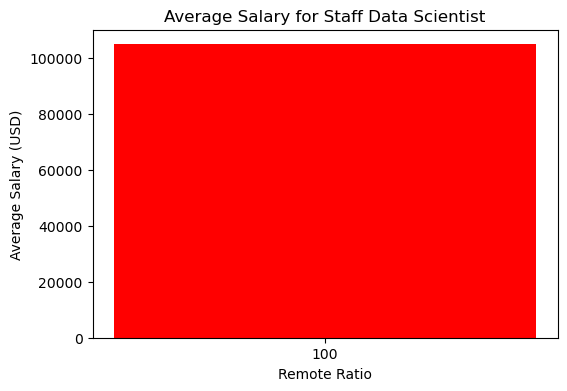

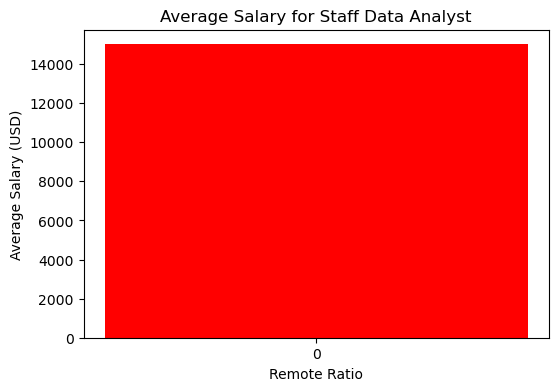

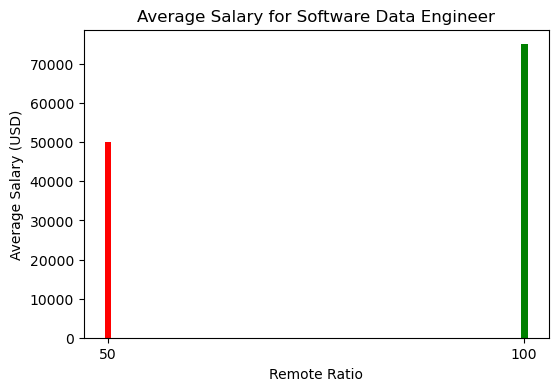

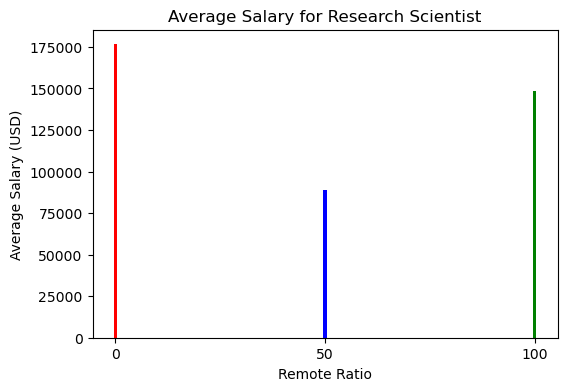

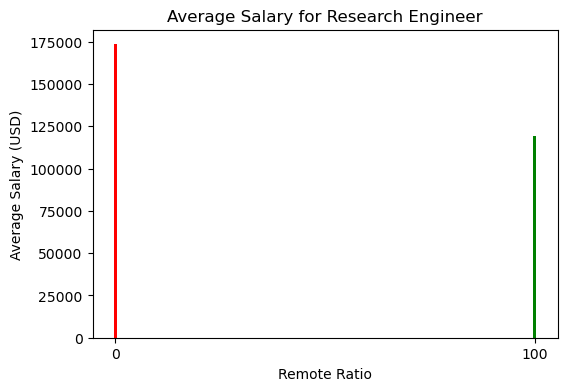

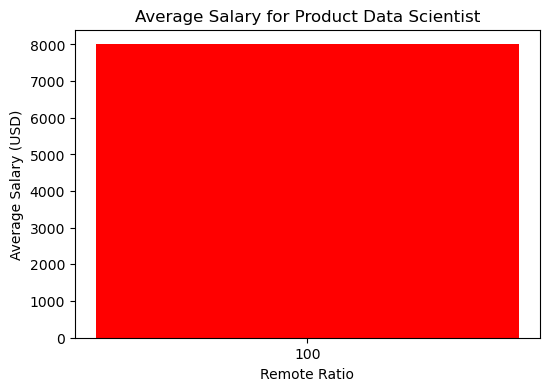

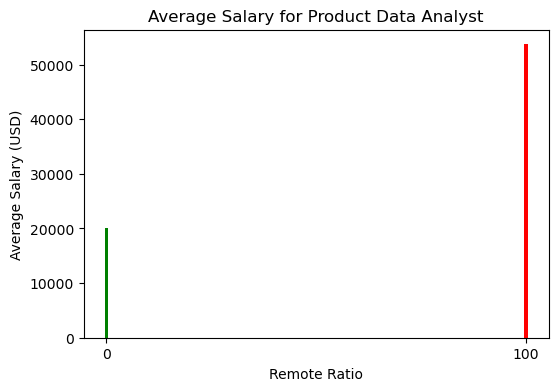

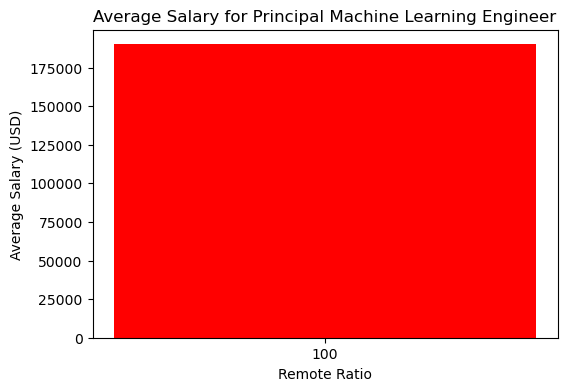

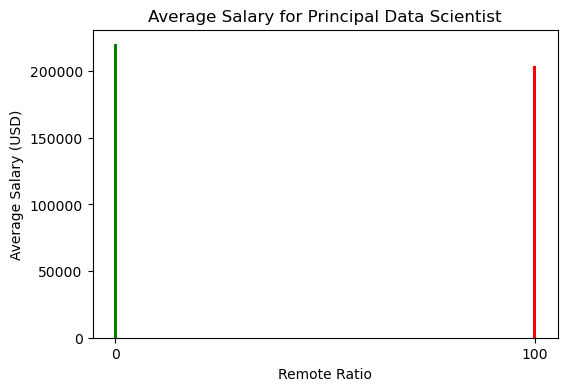

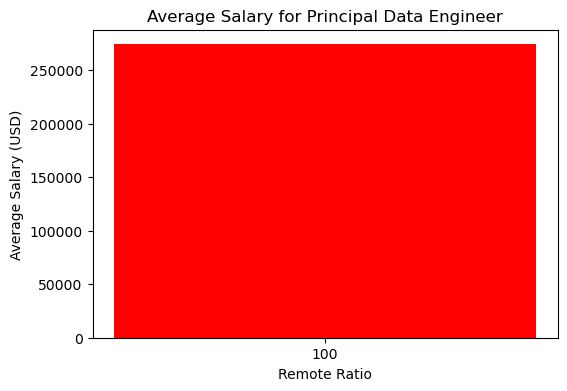

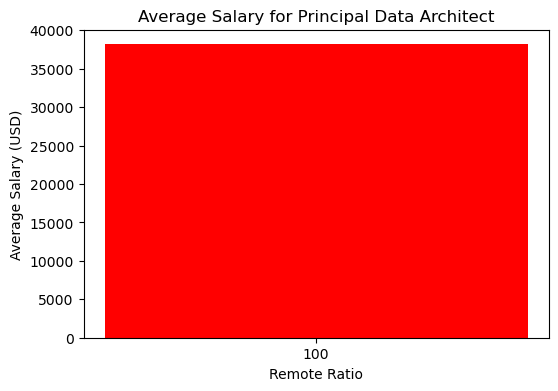

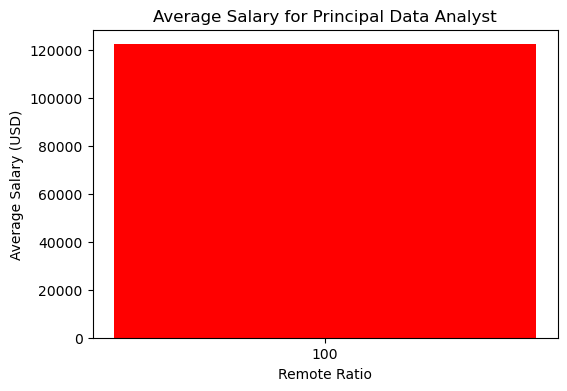

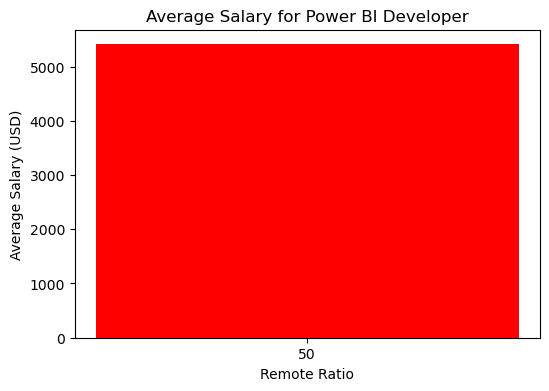

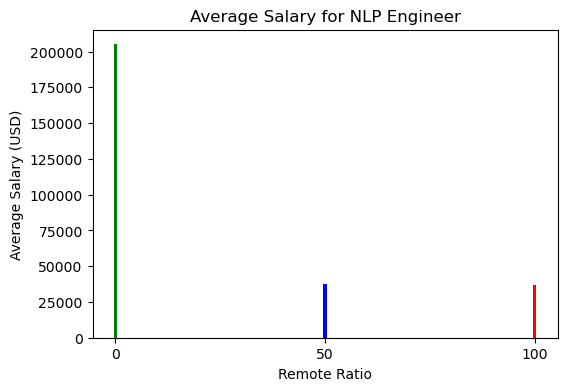

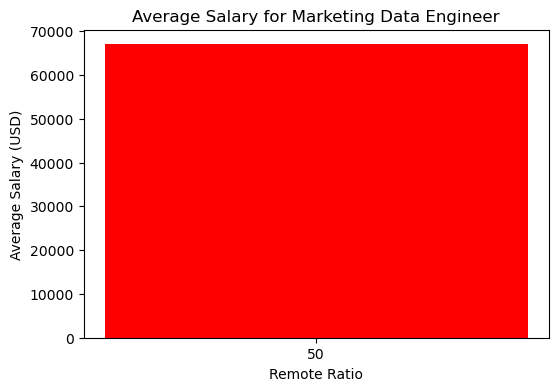

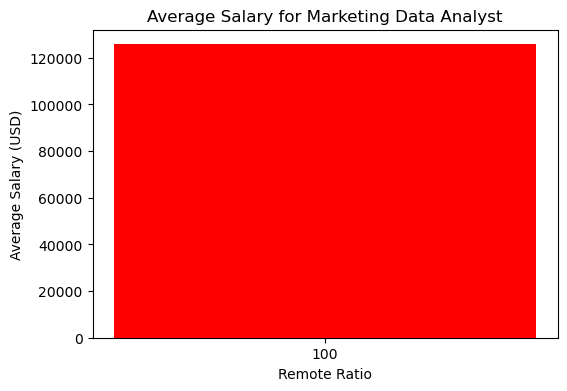

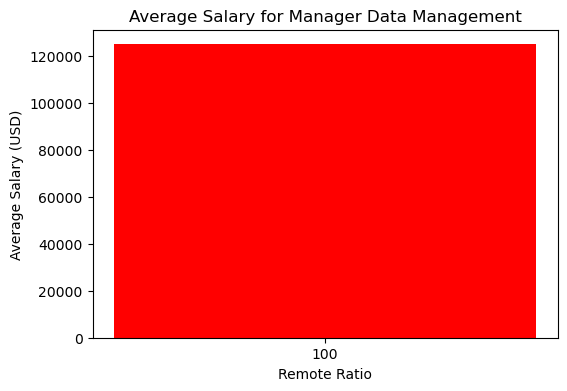

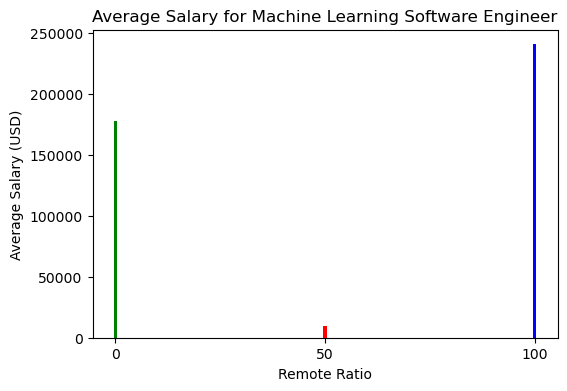

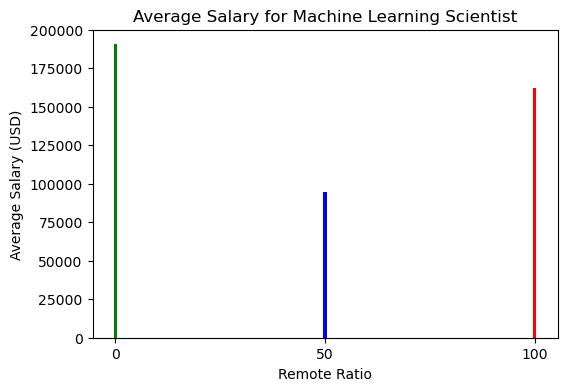

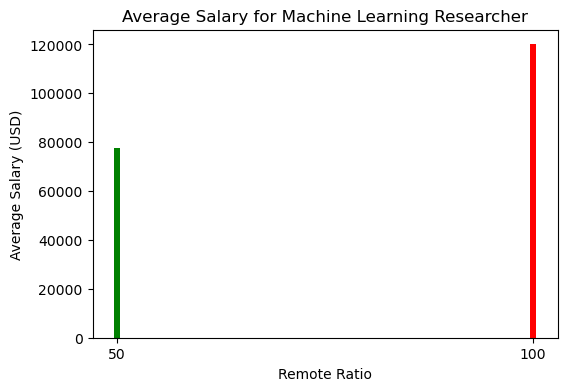

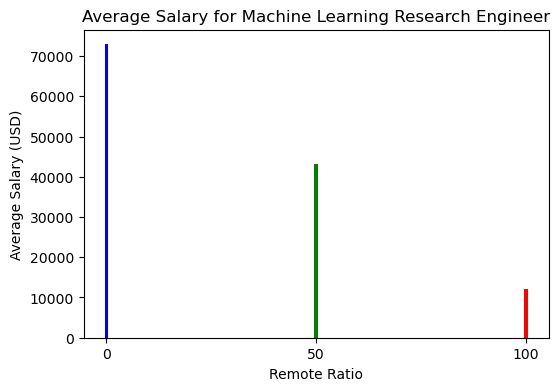

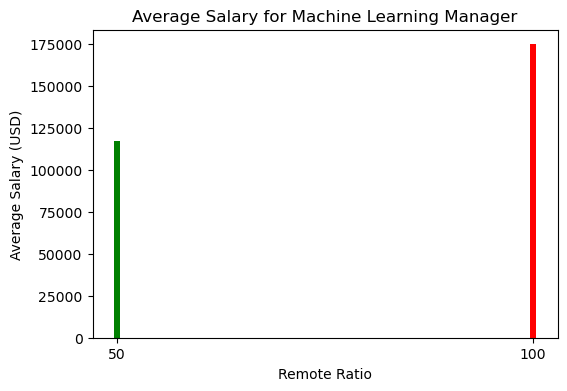

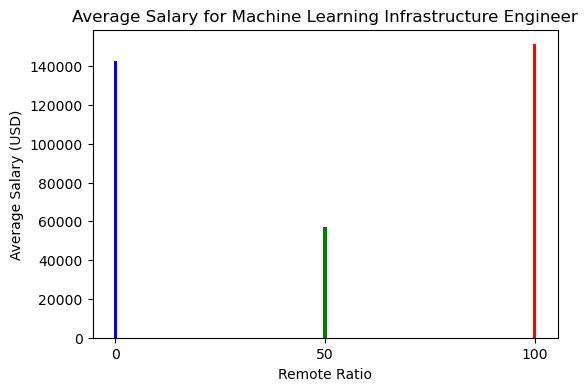

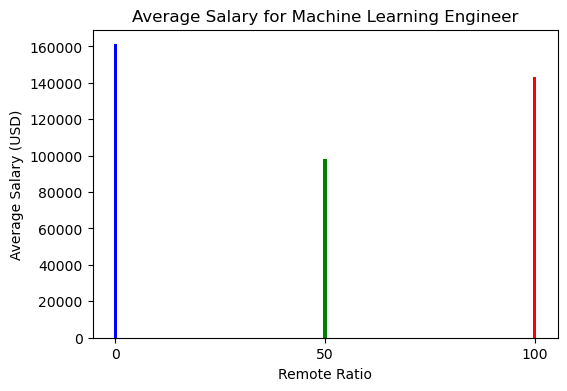

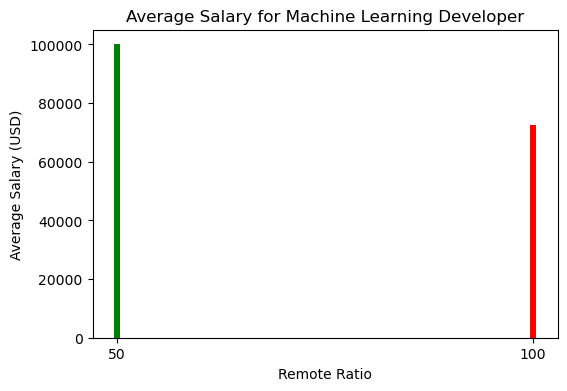

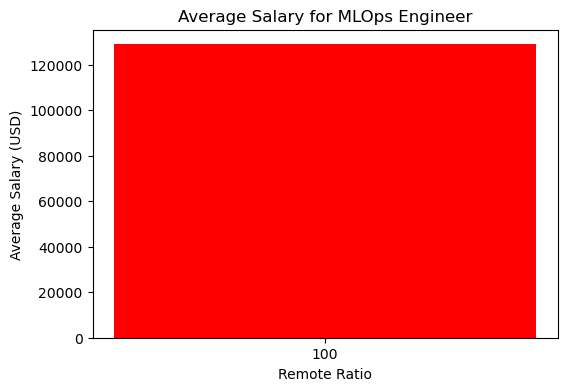

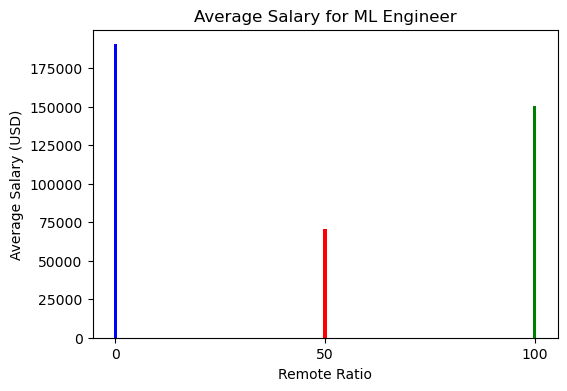

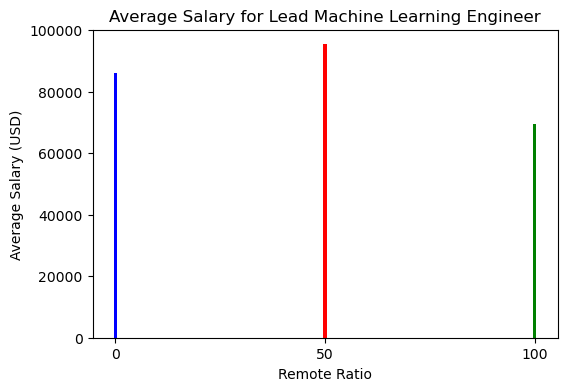

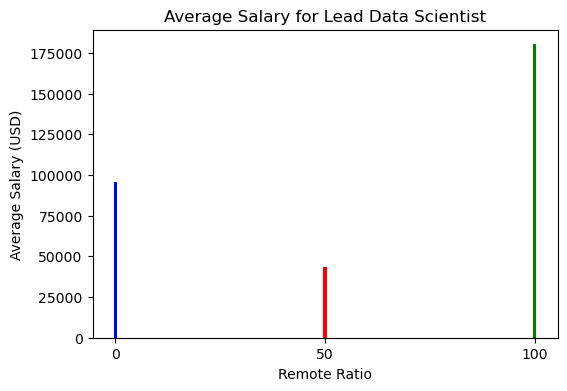

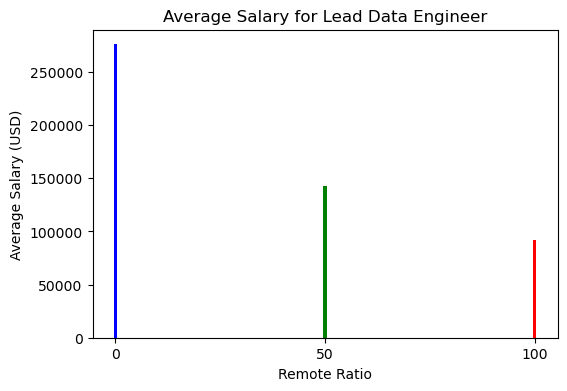

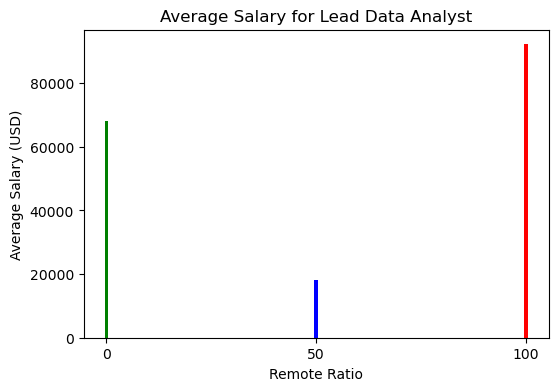

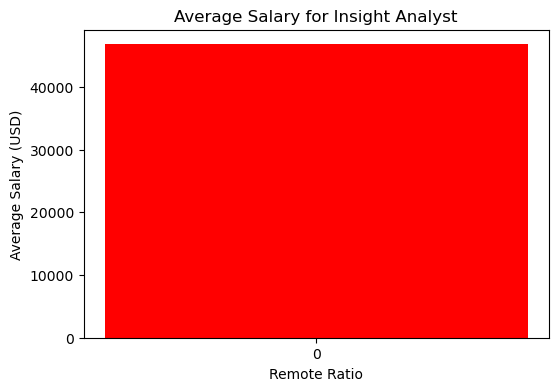

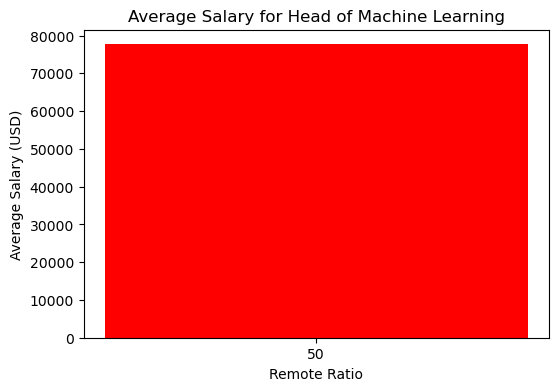

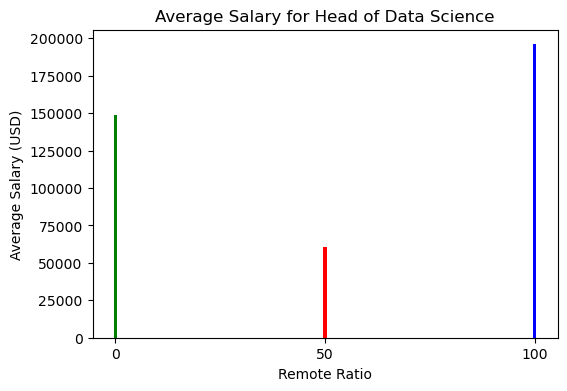

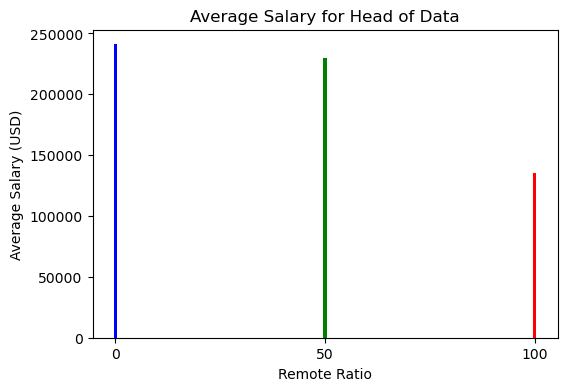

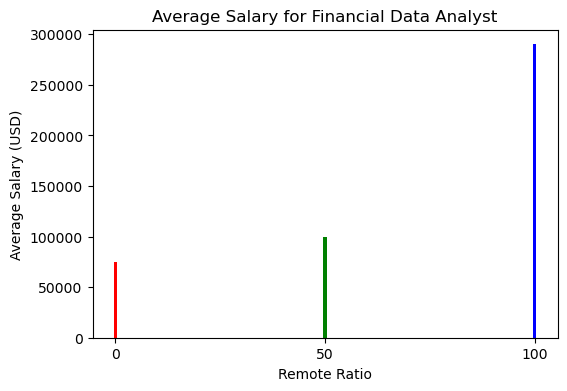

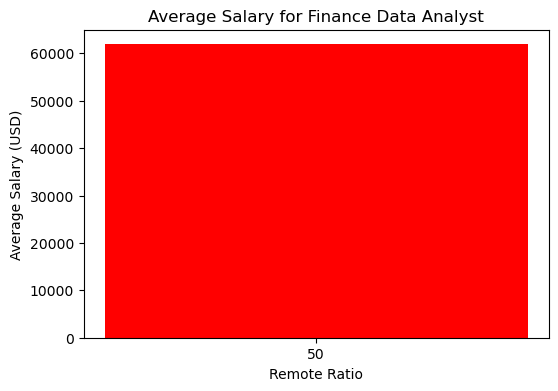

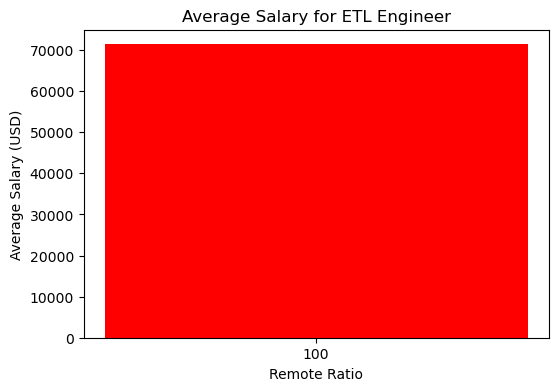

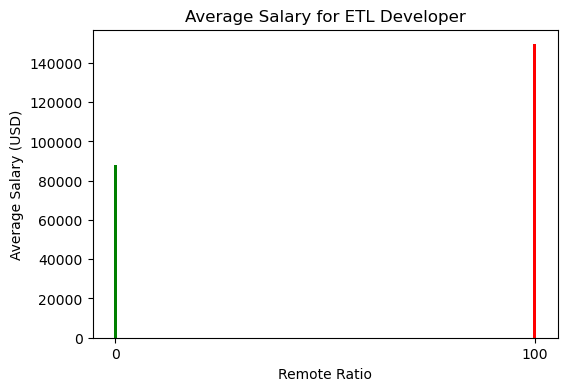

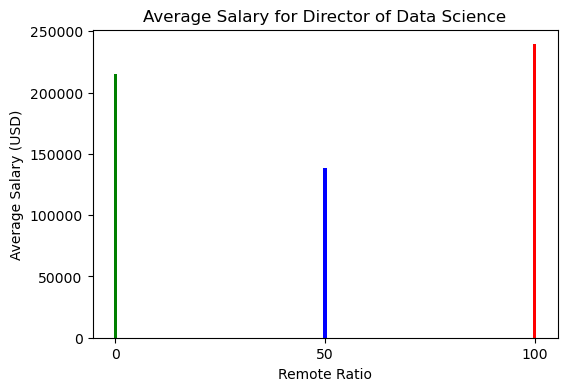

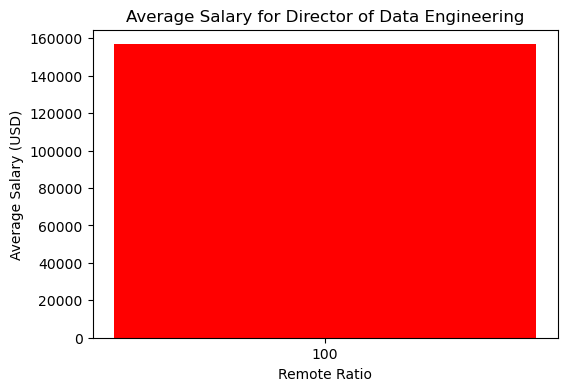

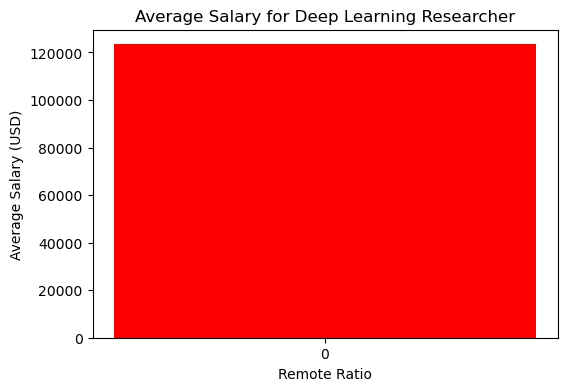

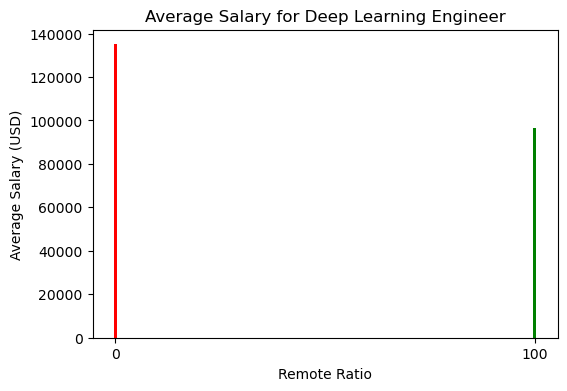

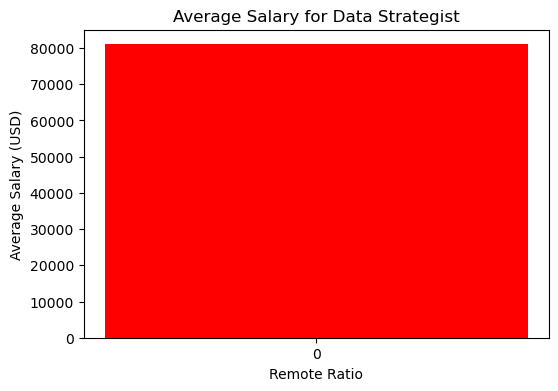

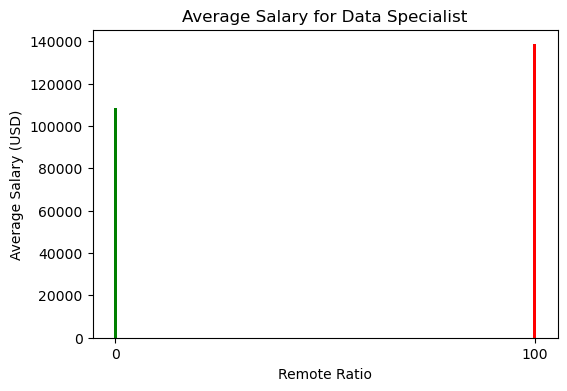

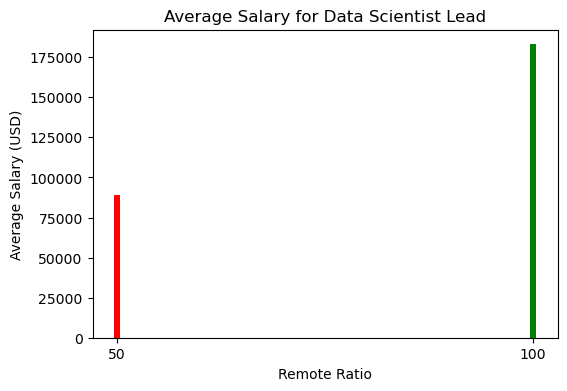

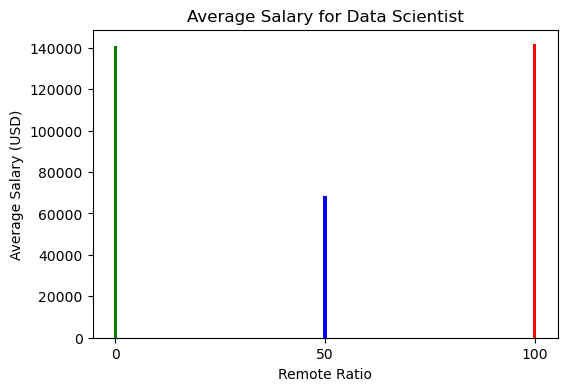

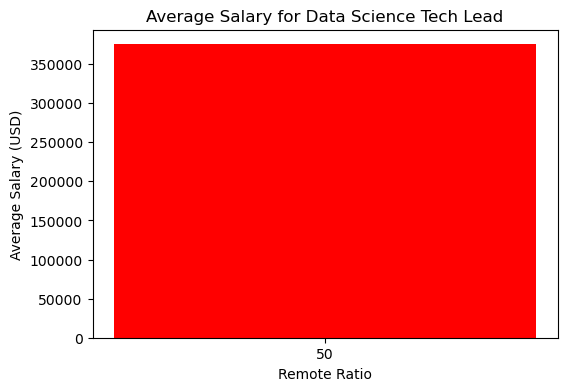

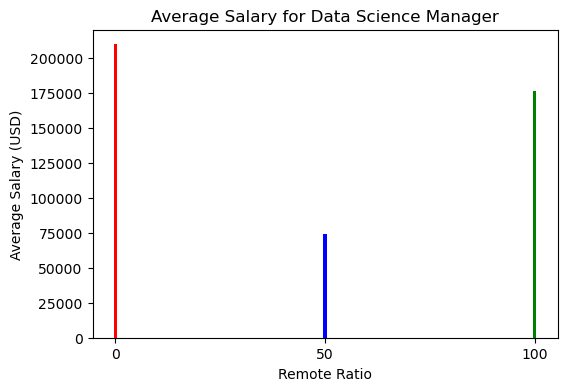

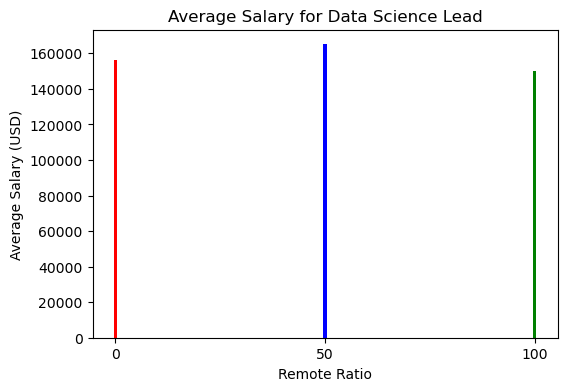

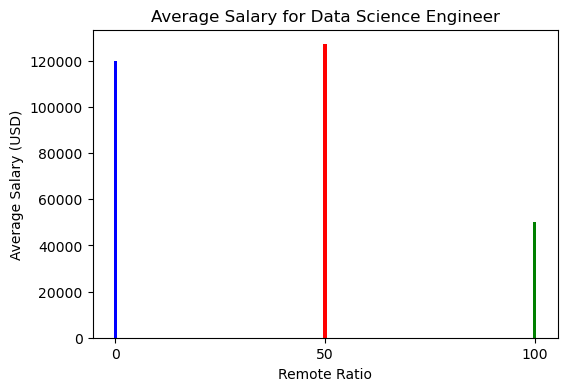

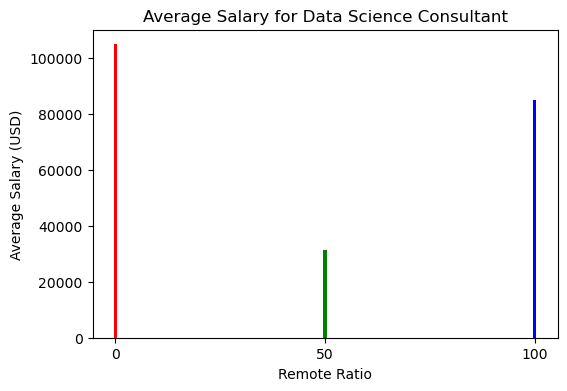

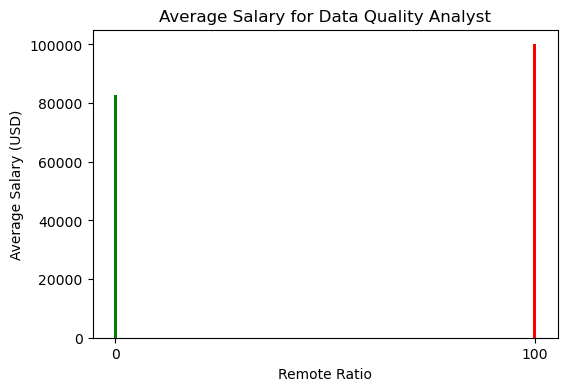

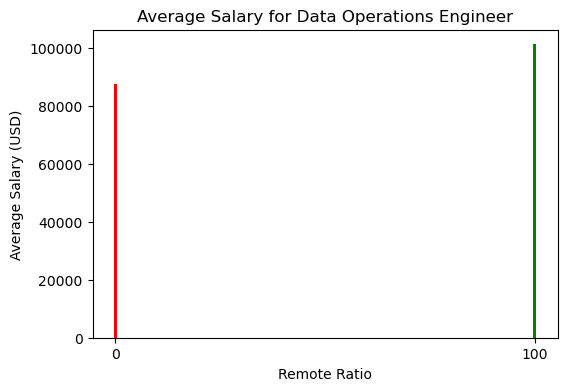

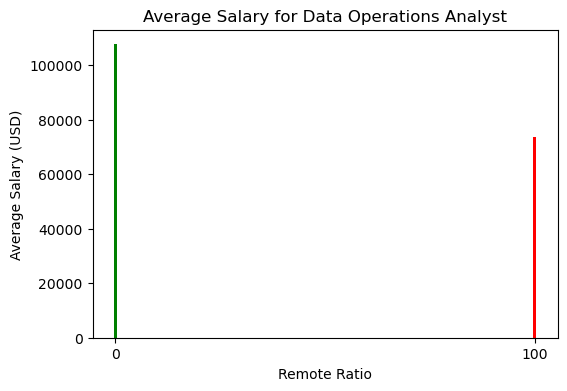

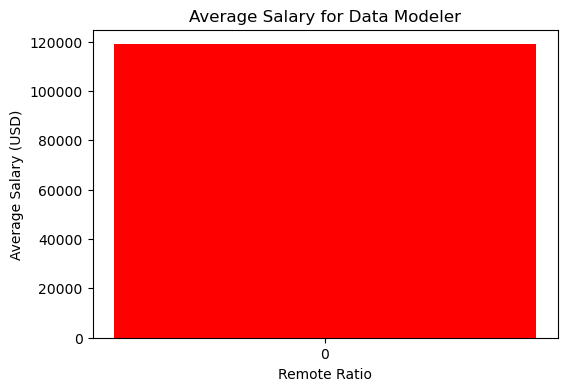

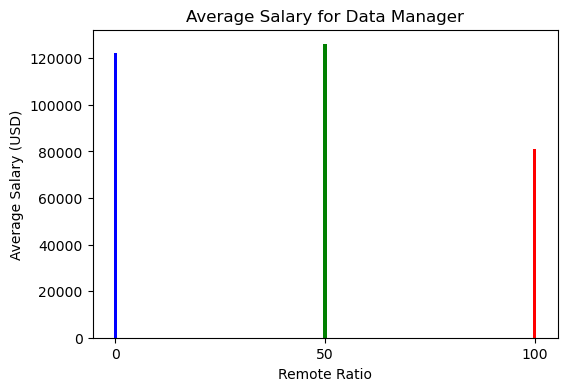

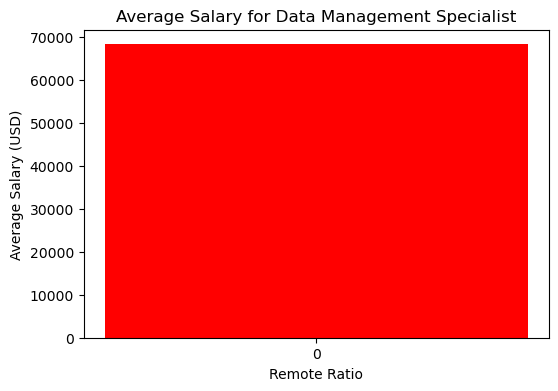

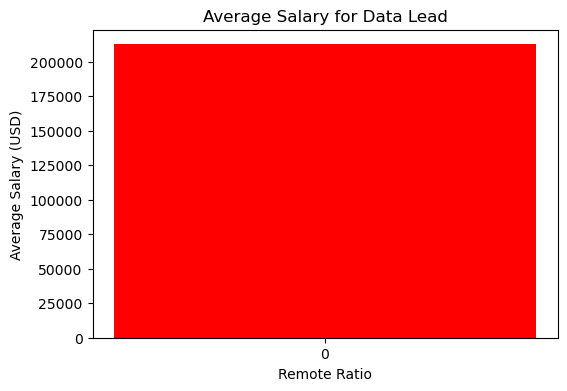

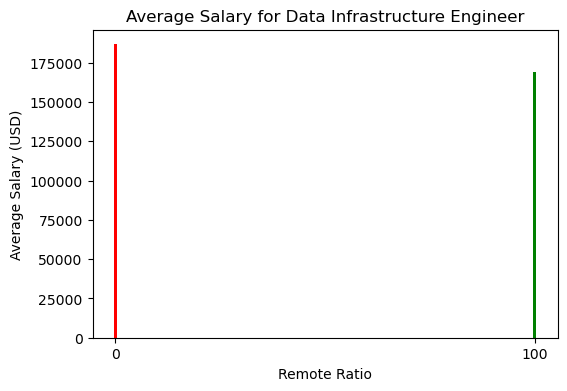

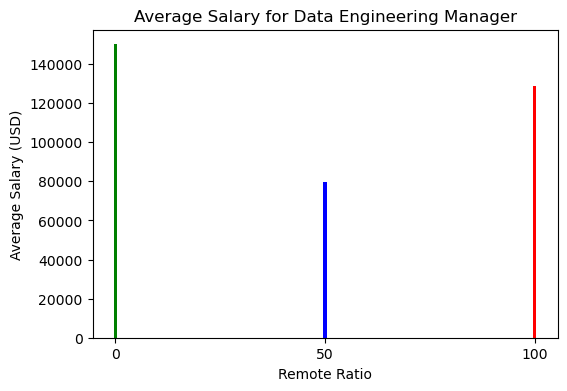

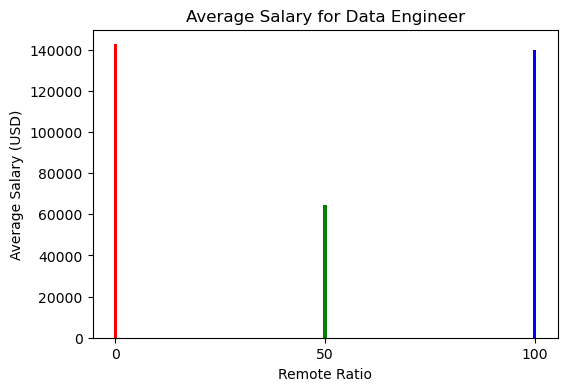

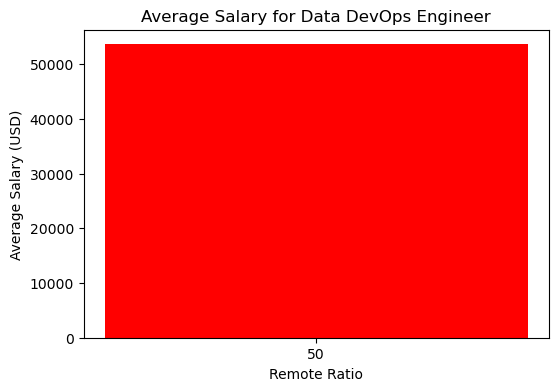

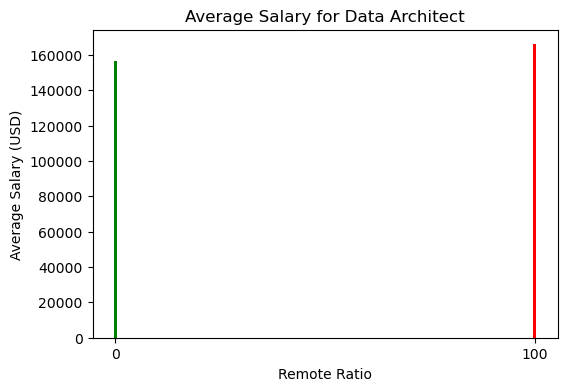

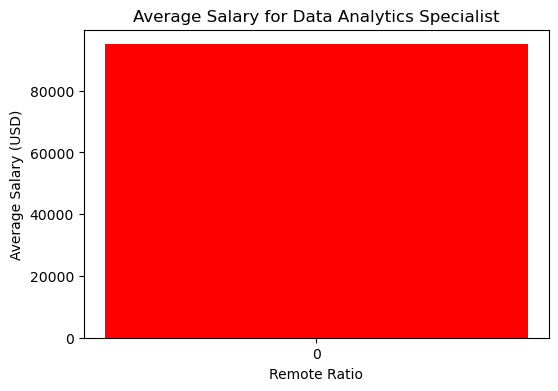

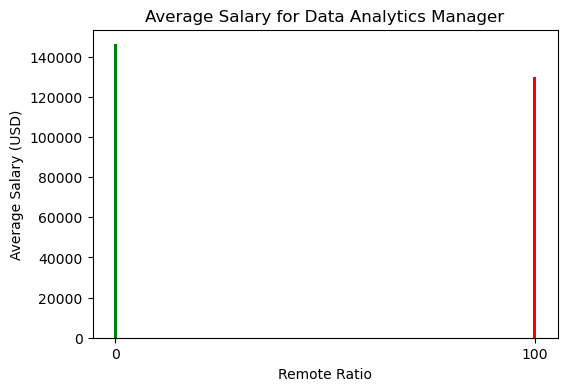

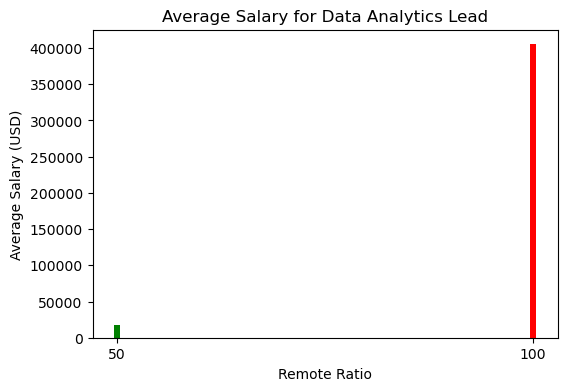

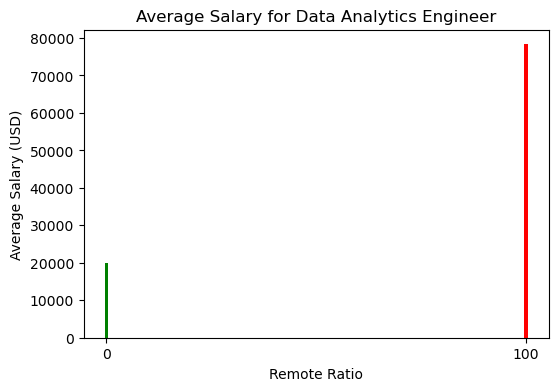

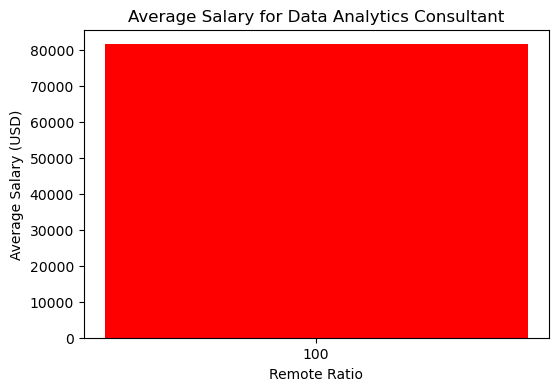

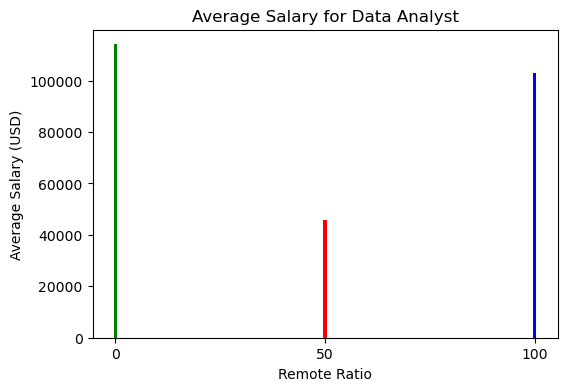

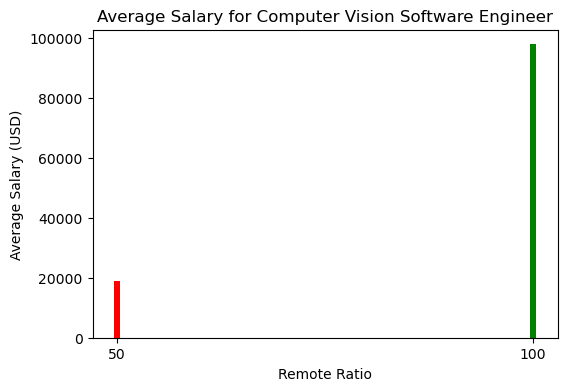

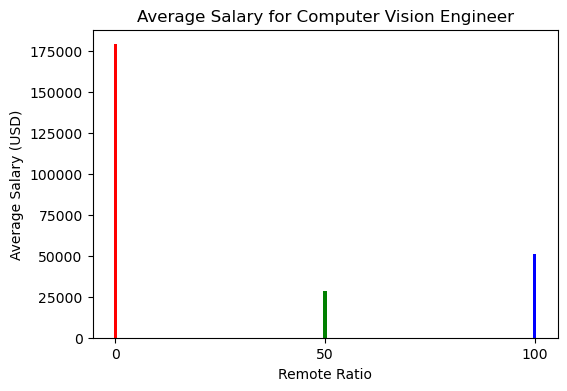

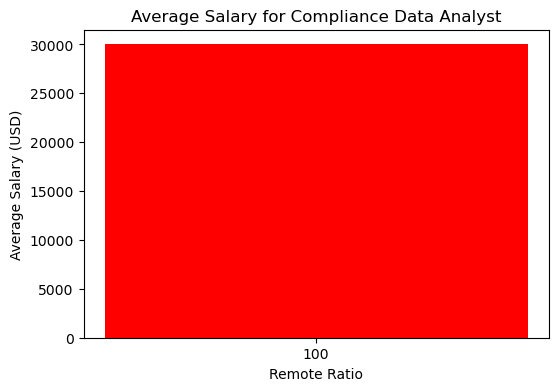

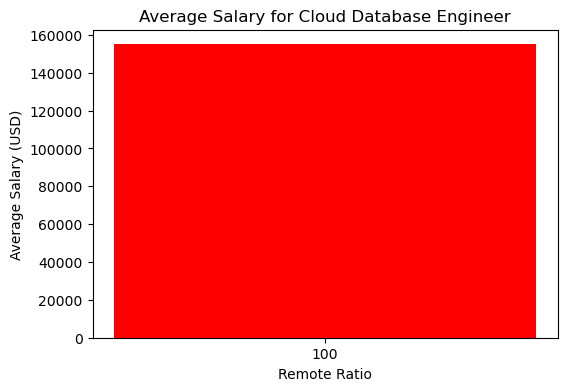

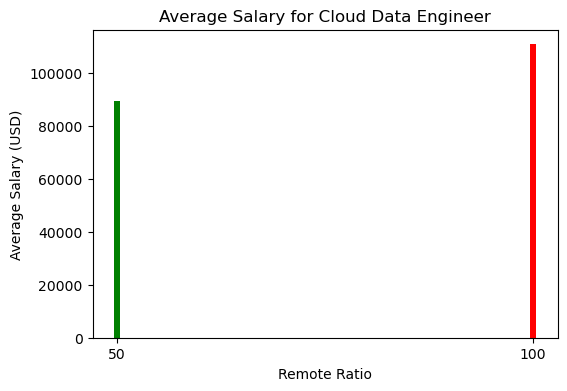

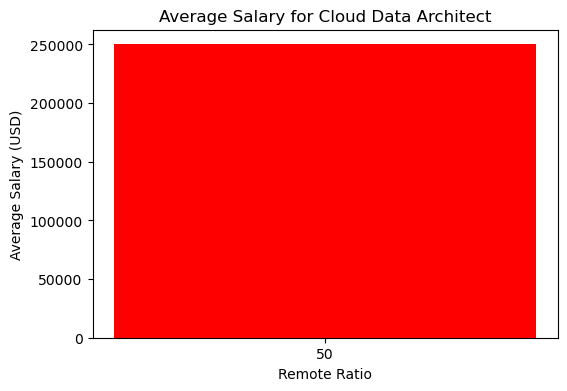

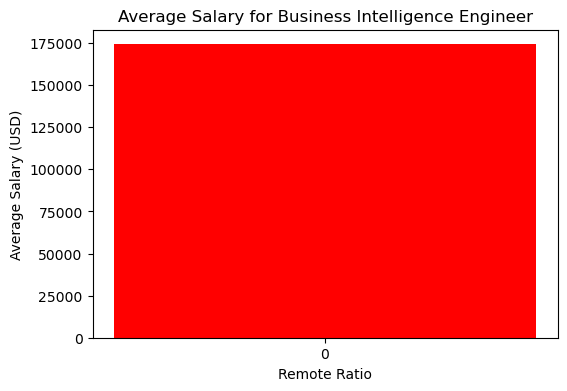

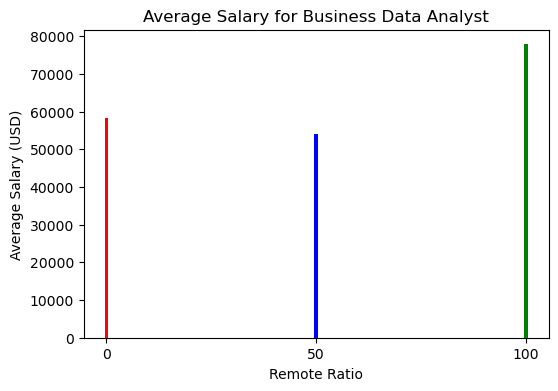

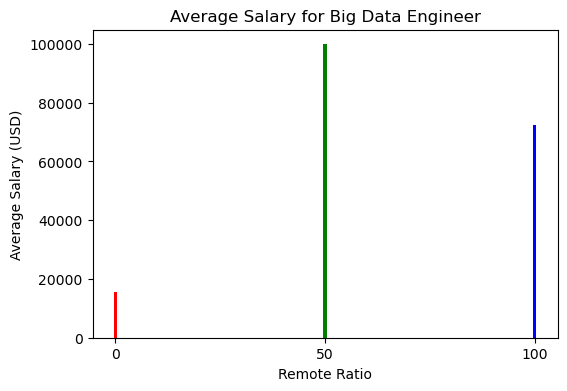

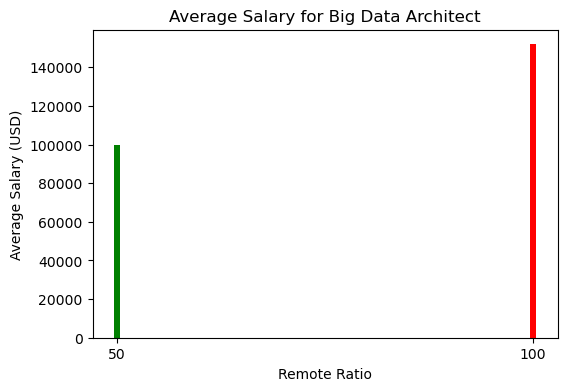

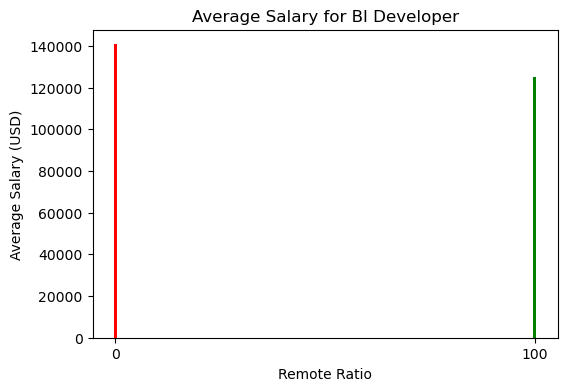

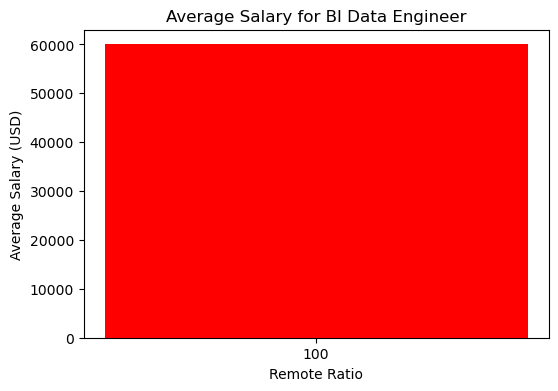

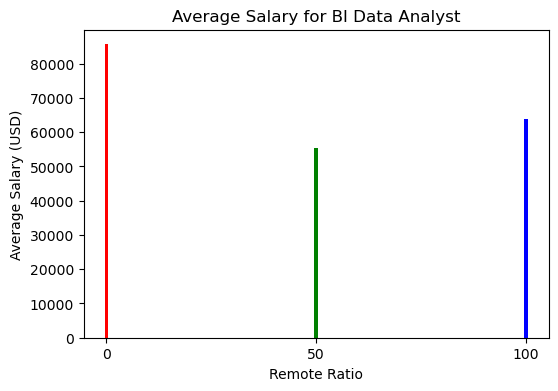

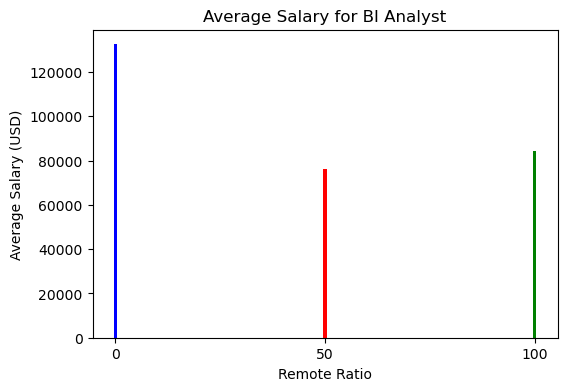

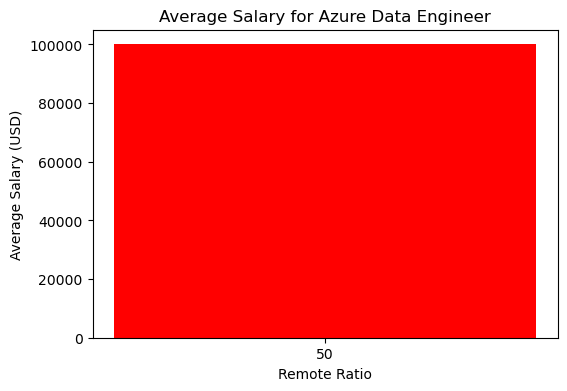

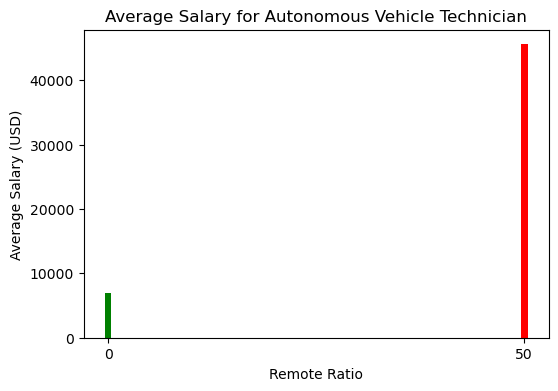

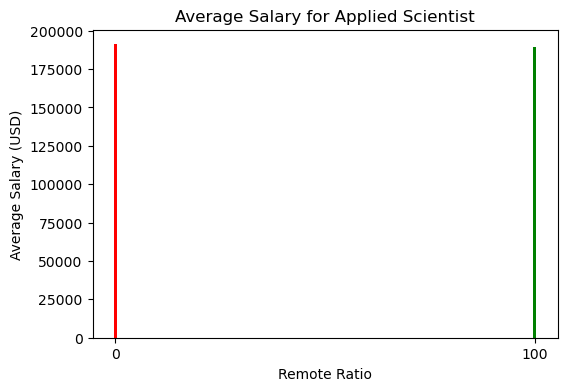

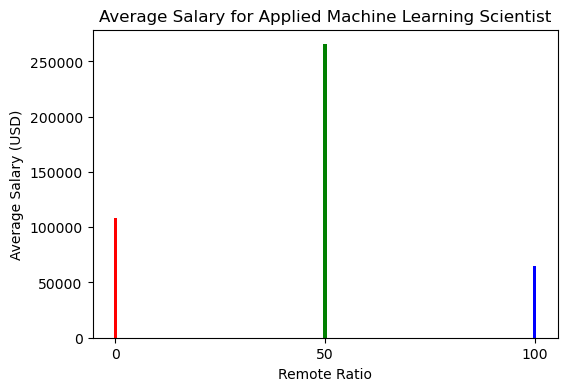

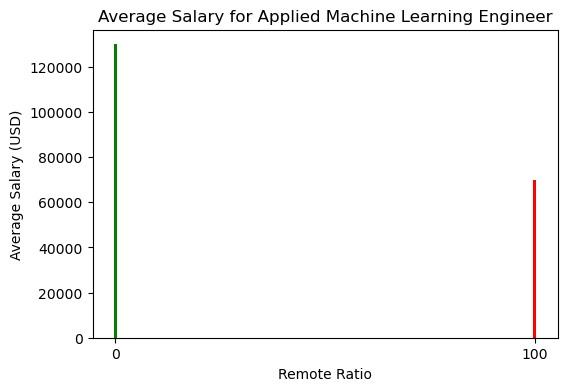

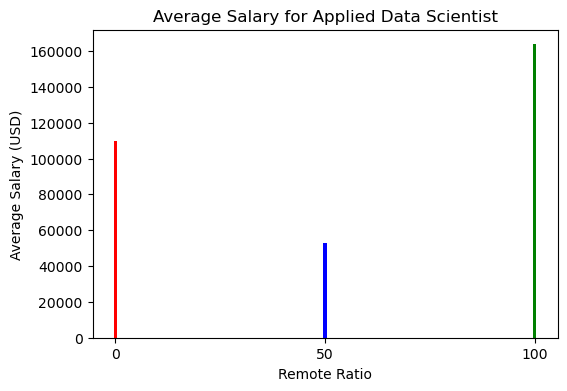

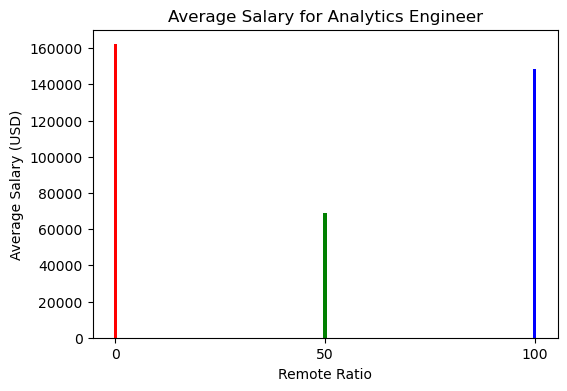

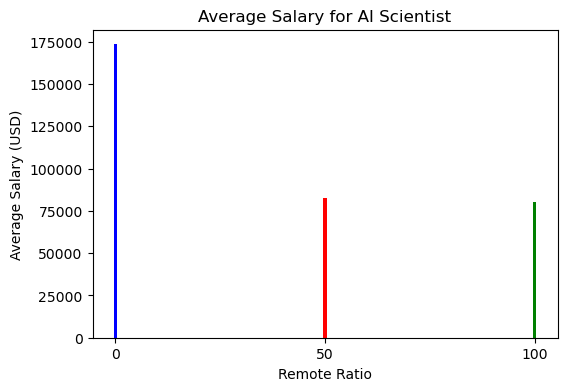

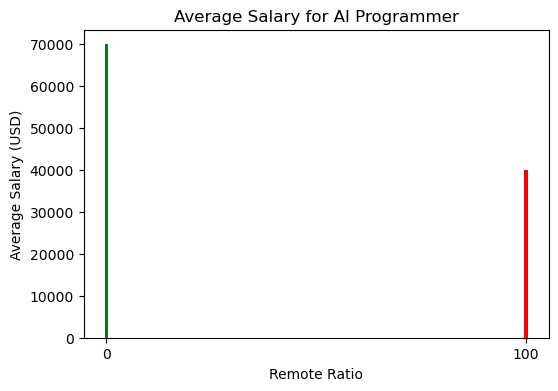

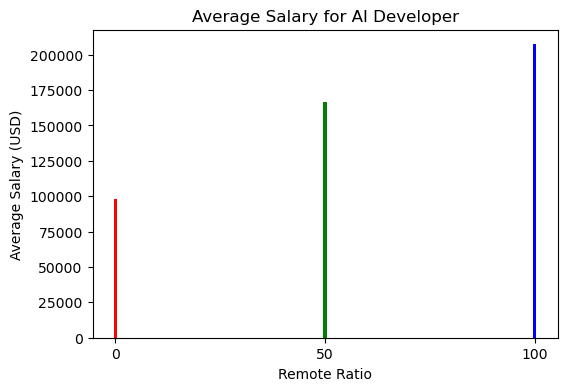

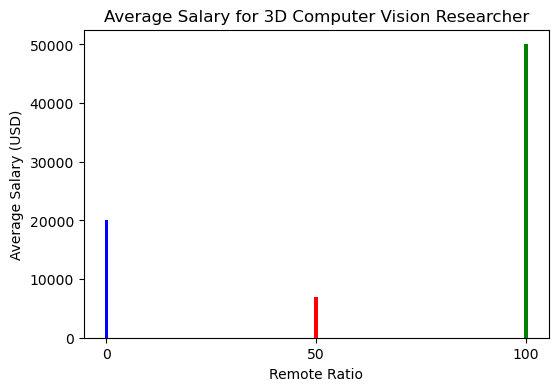

In [14]:
avg_salary_per_year_pd = avg_salary_per_year.toPandas()
for job_title in avg_salary_per_year_pd['job_title'].unique():
    job_data = avg_salary_per_year_pd[avg_salary_per_year_pd['job_title'] == job_title]
    
    plt.figure(figsize=(6, 4))
    plt.bar(job_data['remote_ratio'], job_data['avg_salary'], color=['red', 'green', 'blue'])
    
    plt.title(f'Average Salary for {job_title}')
    plt.xlabel('Remote Ratio')
    plt.ylabel('Average Salary (USD)')
    plt.xticks(job_data['remote_ratio'])
    
    plt.show()

In [13]:
#spark.stop()